In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage.interpolation import map_coordinates
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

Setting environment for Precision WorkStation


No vtk
No vtk/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Plot histogram over whole images.

In [2]:
stack_versions = {'MD585': 'gray',
'MD589': 'gray',
'MD594': 'gray',
'MD635': 'Ntb',
'MD653': 'Ntb',
 'MD652': 'Ntb',
 'MD642': 'Ntb',
 'MD657': 'Ntb',
 'MD658': 'Ntb',
 'MD661': 'Ntb',
 'MD662': 'Ntb' 
}

In [ ]:
# for stack in ['MD585', 'MD589', 'MD594'] + ['MD635'] + ['MD653', 'MD652', 'MD642', 'MD657', 'MD658'] + ['MD661', 'MD662']:
for stack in ['MD635'] + ['MD653', 'MD652', 'MD642', 'MD657', 'MD658'] + ['MD661', 'MD662']:

    structure = '7N'
    
    if stack in ['MD585', 'MD589', 'MD594'] + ['MD658'] + ['MD635']:
        local_region_bboxes_all_sections = get_local_regions(stack, margin_um=200, by_human=True ,
                                                         structures=['7N_L'])
    elif stack in ['MD653', 'MD652', 'MD642', 'MD657']:
        local_region_bboxes_all_sections = get_local_regions(stack, margin_um=200, by_human=False, level=0.5, 
                                                     structures=['7N_L'],
                                                    detector_id_f=13)
    elif stack in ['MD661', 'MD662']:
        local_region_bboxes_all_sections = get_local_regions(stack, margin_um=200, by_human=False, level=0.5, 
                                                     structures=['7N_L'],
                                                    detector_id_f=1)
    else:
        raise
        
    for name_s, bboxes_all_sections in local_region_bboxes_all_sections.iteritems():
        for sec, bbox in bboxes_all_sections.iteritems():

#     for sec in metadata_cache['valid_sections'][stack]:
        
#             try:
            print sec

            NorF = DataManager.get_brightfield_or_fluorescence(stack=stack, sec=sec)

            lossless_img = DataManager.load_image_v2(stack=stack, prep_id=2, section=sec, version=stack_versions[stack])

            tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, section=sec)
            lossless_mask = rescale_by_resampling(tb_mask, 32)

            if NorF == 'N':
                counts, bins = np.histogram(lossless_img[lossless_mask], bins=np.linspace(0, 256, 257));
            elif NorF == 'F':
                counts, bins = np.histogram(lossless_img[lossless_mask], bins=np.linspace(0, 3500, 300));
            else:
                raise

            vmax = lossless_img[lossless_mask].max()
            vmin = lossless_img[lossless_mask].min()

            fig = plt.figure(figsize=(10, 5));
            plt.bar(bins[:-1], counts, align='center')
            if NorF == 'N':
                plt.xlim([-1, 256]);
                plt.xticks(np.r_[bins[::50], vmin, vmax])
            else:
                plt.xlim([-1, 3500]);
                plt.xticks(np.r_[bins[::50], vmin, vmax])
            plt.axvline(x=vmax, c='r');
            plt.axvline(x=vmin, c='r');
            plt.title('Histogram (linear)');
            plt.xlabel('Pixel intensity');
    #                 plt.show();

            plot_fp = os.path.join(ROOT_DIR, 'raw_image_histograms_fullImage', stack, '%s_%d%s.png' % (stack, sec, NorF))
            create_parent_dir_if_not_exists(plot_fp)
            plt.savefig(fname=plot_fp, bbox_inches='tight');
            plt.close(fig);
            upload_to_s3(plot_fp)

            counts_log = np.log(counts)

            fig = plt.figure(figsize=(10, 5));
            plt.bar(bins[:-1], counts_log, width=np.diff(bins)[0]*.8, align='center');
            if NorF == 'N':
                plt.xlim([-1, 256]);
                plt.xticks(np.r_[bins[::50], vmin, vmax])
            else:
                plt.xlim([-1, 3500]);
                plt.xticks(np.r_[bins[::50], vmin, vmax])

            plt.axvline(x=vmax, c='r');
            plt.axvline(x=vmin, c='r');
            plt.title('Histogram (log)');
            plt.xlabel('Pixel intensity');
    #                 plt.show();

            plot_fp = os.path.join(ROOT_DIR, 'raw_image_histograms_log_fullImage', stack, '%s_%d%s.png' % (stack, sec, NorF))
            create_parent_dir_if_not_exists(plot_fp)
            plt.savefig(fname=plot_fp, bbox_inches='tight');
            plt.close(fig);
            upload_to_s3(plot_fp)
#             except:
#                 pass

In [2]:
stack_versions = {'CHATM2': 'Ntb'}

In [3]:
nissl_bins = np.linspace(0, 256, 257)
ntb_bins = np.linspace(0, 65536, 300)

In [8]:
for stack in ['CHATM2']:

#     for sec in metadata_cache['valid_sections'][stack][::10]:
    for sec in range(150, 170):
        
        try:
        
            print sec

            NorF = DataManager.get_brightfield_or_fluorescence(stack=stack, sec=sec)

            lossless_img = DataManager.load_image_v2(stack=stack, prep_id=2, section=sec, version=stack_versions[stack])

            tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, section=sec)
            lossless_mask = rescale_by_resampling(tb_mask, 32)

            if NorF == 'N':
                counts, bins = np.histogram(lossless_img[lossless_mask], bins=nissl_bins);
            elif NorF == 'F':
                counts, bins = np.histogram(lossless_img[lossless_mask], bins=ntb_bins);
            else:
                raise

            vmax = lossless_img[lossless_mask].max()
            vmin = lossless_img[lossless_mask].min()

#             fig = plt.figure(figsize=(10, 5));
#             plt.bar(bins[:-1], counts, align='center')
#             if NorF == 'N':
#                 plt.xlim([-1, nissl_bins[-1]]);
#                 plt.xticks(np.r_[bins[::50], vmin, vmax], rotation=60)
#             else:
#                 plt.xlim([-1, ntb_bins[-1]]);
#                 plt.xticks(np.r_[bins[::50], vmin, vmax], rotation=60)
#             plt.axvline(x=vmax, c='r');
#             plt.axvline(x=vmin, c='r');
#             plt.title('Histogram (linear)');
#             plt.xlabel('Pixel intensity');
#             plt.show();

#             plot_fp = os.path.join(ROOT_DIR, 'raw_image_histograms_fullImage', stack, '%s_%d%s.png' % (stack, sec, NorF))
#             create_parent_dir_if_not_exists(plot_fp)
#             plt.savefig(fname=plot_fp, bbox_inches='tight');
#             plt.close(fig);
#             upload_to_s3(plot_fp)

            counts_log = np.log(counts)

            fig = plt.figure(figsize=(10, 5));
            plt.bar(bins[:-1], counts_log, width=np.diff(bins)[0]*.8, align='center');
            if NorF == 'N':
                plt.xlim([-1, nissl_bins[-1]]);
                plt.xticks(np.r_[bins[::50], vmin, vmax], rotation=60)
            else:
                plt.xlim([-1, ntb_bins[-1]]);
                plt.xticks(np.r_[bins[::50], vmin, vmax], rotation=60)

            plt.axvline(x=vmax, c='r');
            plt.axvline(x=vmin, c='r');
            plt.title('Histogram (log)');
            plt.xlabel('Pixel intensity');
#             plt.show();

            plot_fp = os.path.join(ROOT_DIR, 'raw_image_histograms_log_fullImage', stack, '%s_%d%s.png' % (stack, sec, NorF))
            create_parent_dir_if_not_exists(plot_fp)
            plt.savefig(fname=plot_fp, bbox_inches='tight');
            plt.close(fig);
            upload_to_s3(plot_fp)
            
        except Exception as e:
            print e
            pass

150


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide50_2018_01_22-S3_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_150F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_150F.png"
0
151


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide51_2018_01_22-S1_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_151F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_151F.png"
0
152


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide51_2018_01_22-S2_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_152F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_152F.png"
0
153


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide51_2018_01_22-S3_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_153F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_153F.png"
0
154


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide52_2018_01_22-S1_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_154F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_154F.png"
0
155


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide52_2018_01_22-S2_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_155F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_155F.png"
0
156


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide52_2018_01_22-S3_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_156F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_156F.png"
0
157


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide53_2018_01_22-S1_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_157F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_157F.png"
0
158


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide53_2018_01_22-S2_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_158F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_158F.png"
0
159


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide53_2018_01_22-S3_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_159F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_159F.png"
0
160


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide54_2018_01_22-S1_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_160F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_160F.png"
0
161


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide54_2018_01_22-S2_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_161F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_161F.png"
0
162


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide54_2018_01_22-S3_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_162F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_162F.png"
0
163


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide55_2018_01_22-S1_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_163F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_163F.png"
0
164


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide55_2018_01_22-S2_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_164F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_164F.png"
0
165


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide55_2018_01_22-S3_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_165F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_165F.png"
0
166


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide56_2018_01_22-S1_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_166F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_166F.png"
0
167


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide56_2018_01_22-S2_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_167F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_167F.png"
0
168


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide56_2018_01_22-S3_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_168F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_168F.png"
0
169


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide57_2018_01_22-S1_prep2_lossless_Ntb.tif
aws s3 cp "/home/yuncong/raw_image_histograms_log_fullImage/CHATM2/CHATM2_169F.png" "s3://mousebrainatlas-data/raw_image_histograms_log_fullImage/CHATM2/CHATM2_169F.png"
0


In [9]:
def is_on_mask(tb_mask, bbox):
    tb_region_xmin = bbox[0] / 32
    tb_region_xmax = bbox[1] / 32
    tb_region_ymin = bbox[2] / 32
    tb_region_ymax = bbox[3] / 32
    
    if tb_region_xmax > tb_mask.shape[1] or tb_region_ymax > tb_mask.shape[0]:
        return False

    if not np.all(np.r_[tb_mask[tb_region_ymin, tb_region_xmin],
        tb_mask[tb_region_ymin, tb_region_xmax],
        tb_mask[tb_region_ymax, tb_region_xmin],
        tb_mask[tb_region_ymax, tb_region_xmax]]):
        return False

    return True

In [ ]:
# for section in metadata_cache['valid_sections'][stack]:
for sec in range(150, 170):
    
    print section
    
    img = DataManager.load_image_v2(stack=stack, prep_id=2, section=section, version='Ntb')
    tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=2, section=section)
    
    mean_std_all_regions = []
    cx_cy_all_regions = []
    # region_size = 4000
    # region_spacing = region_size/4
    region_size = 5000
    region_spacing = 1000
    for cx in range(region_size, img.shape[1]-region_size, region_spacing):
        for cy in range(region_size, img.shape[0]-region_size, region_spacing):
            if is_on_mask(tb_mask, (cx-region_size/2, cx+region_size/2+1, cy-region_size/2, cy+region_size/2+1)):
                reg = img[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1]
                mean_std_all_regions.append((reg.mean(), reg.std()))
                cx_cy_all_regions.append((cx, cy))
                
    mean_map = resample_scoremap(np.array(mean_std_all_regions)[:,0], np.array(cx_cy_all_regions), 
                  img_shape=metadata_cache['image_shape'][stack], 
                             downscale=32, out_dtype=np.float32,
                            half_size=region_size/2, spacing=region_spacing)
    
#     plt.figure(figsize=(10,10));
#     plt.imshow(mean_map);
#     plt.colorbar();

    std_map = resample_scoremap(np.array(mean_std_all_regions)[:,1], np.array(cx_cy_all_regions), 
                  img_shape=metadata_cache['image_shape'][stack], 
                             downscale=32, out_dtype=np.float32,
                            half_size=region_size/2, spacing=region_spacing)
    
#     plt.figure(figsize=(10,10));
#     plt.imshow(std_map);
#     plt.colorbar();

    mean_std_sample_locations = \
    {(x,y): (mean_map[y/32, x/32], std_map[y/32, x/32])
     for x,y in grid_parameters_to_sample_locations(win_id_to_gridspec(win_id=5, stack=stack))}
    
    save_pickle(mean_std_sample_locations, ROOT_DIR + '/sample_locations_mean_std/%s_%d_sample_locations_mean_std.pkl' % (stack, section))

In [82]:
metadata_cache['sections_to_filenames']['MD589']

{1: 'MD589-N1-2015.07.30-16.19.59_MD589_1_0001',
 2: 'MD589-IHC1-2015.07.30-21.30.07_MD589_1_0001',
 3: 'MD589-N1-2015.07.30-16.19.59_MD589_2_0002',
 4: 'MD589-IHC1-2015.07.30-21.30.07_MD589_2_0002',
 5: 'MD589-N1-2015.07.30-16.19.59_MD589_3_0003',
 6: 'MD589-IHC1-2015.07.30-21.30.07_MD589_3_0003',
 7: 'MD589-N2-2015.07.30-16.22.26_MD589_1_0004',
 8: 'MD589-IHC2-2015.07.30-21.32.04_MD589_1_0004',
 9: 'MD589-N2-2015.07.30-16.22.26_MD589_2_0005',
 10: 'MD589-IHC2-2015.07.30-21.32.04_MD589_2_0005',
 11: 'MD589-N2-2015.07.30-16.22.26_MD589_3_0006',
 12: 'MD589-IHC2-2015.07.30-21.32.04_MD589_3_0006',
 13: 'MD589-N3-2015.07.30-16.25.24_MD589_1_0007',
 14: 'MD589-IHC3-2015.07.30-21.34.34_MD589_1_0007',
 15: 'MD589-N3-2015.07.30-16.25.24_MD589_2_0008',
 16: 'MD589-IHC3-2015.07.30-21.34.34_MD589_2_0008',
 17: 'MD589-N3-2015.07.30-16.25.24_MD589_3_0009',
 18: 'MD589-IHC3-2015.07.30-21.34.34_MD589_3_0009',
 19: 'MD589-N4-2015.07.30-16.28.25_MD589_1_0010',
 20: 'MD589-IHC4-2015.07.30-21.37.21_MD58

In [81]:
metadata_cache['sections_to_filenames']['CHATM2']

{1: 'CHATM2_slide01_2018_01_18-S1',
 2: 'CHATM2_slide01_2018_01_18-S2',
 3: 'CHATM2_slide01_2018_01_18-S3',
 4: 'CHATM2_slide02_2018_01_18-S1',
 5: 'CHATM2_slide02_2018_01_18-S2',
 6: 'CHATM2_slide02_2018_01_18-S3',
 7: 'CHATM2_slide03_2018_01_18-S1',
 8: 'CHATM2_slide03_2018_01_18-S2',
 9: 'CHATM2_slide03_2018_01_18-S3',
 10: 'CHATM2_slide04_2018_01_18-S1',
 11: 'CHATM2_slide04_2018_01_18-S2',
 12: 'CHATM2_slide04_2018_01_18-S3',
 13: 'CHATM2_slide05_2018_01_18-S1',
 14: 'CHATM2_slide05_2018_01_18-S2',
 15: 'CHATM2_slide05_2018_01_18-S3',
 16: 'CHATM2_slide06_2018_01_18-S1',
 17: 'CHATM2_slide06_2018_01_18-S2',
 18: 'CHATM2_slide06_2018_01_18-S3',
 19: 'CHATM2_slide07_2018_01_18-S1',
 20: 'CHATM2_slide07_2018_01_18-S2',
 21: 'CHATM2_slide07_2018_01_18-S3',
 22: 'CHATM2_slide08_2018_01_18-S1',
 23: 'CHATM2_slide08_2018_01_18-S2',
 24: 'CHATM2_slide08_2018_01_18-S3',
 25: 'CHATM2_slide09_2018_01_18-S1',
 26: 'CHATM2_slide09_2018_01_18-S2',
 27: 'CHATM2_slide09_2018_01_18-S3',
 28: 'CHAT

In [86]:
[('CHATM2', metadata_cache['sections_to_filenames']['CHATM2'][sec], 'Ntb') for sec in range(195,207,2)]

[('CHATM2', 'CHATM2_slide66_2018_02_14-S2', 'Ntb'),
 ('CHATM2', 'CHATM2_slide66_2018_02_14-S3', 'Ntb'),
 ('CHATM2', 'CHATM2_slide68_2018_02_14-S1', 'Ntb'),
 ('CHATM2', 'CHATM2_slide68_2018_02_14-S2', 'Ntb'),
 ('CHATM2', 'Placeholder', 'Ntb'),
 ('CHATM2', 'CHATM2_slide70_2018_02_14-S1', 'Ntb')]

In [84]:
[('MD589', metadata_cache['sections_to_filenames']['MD589'][sec], 'blue') for sec in range(208,220,2)]

[('MD589', 'MD589-N38-2015.07.30-18.36.50_MD589_2_0113', 'blue'),
 ('MD589', 'MD589-N39-2015.07.30-18.40.43_MD589_1_0115', 'blue'),
 ('MD589', 'MD589-N39-2015.07.30-18.40.43_MD589_2_0116', 'blue'),
 ('MD589', 'MD589-N40-2015.07.30-18.44.48_MD589_1_0118', 'blue'),
 ('MD589', 'MD589-N40-2015.07.30-18.44.48_MD589_2_0119', 'blue'),
 ('MD589', 'MD589-N41-2015.07.30-18.48.44_MD589_1_0121', 'blue')]

In [13]:
image_identifiers = [('CHATM2', 'CHATM2_slide27_2018_01_18-S1', 'Ntb')  
#     ('CHATM2', 'CHATM2_slide66_2018_02_14-S2', 'Ntb'), #195
#  ('MD589', 'MD589-IHC38-2015.07.30-23.54.24_MD589_2_0113', 'blue'),
#                       ('CHATM2', 'CHATM2_slide66_2018_02_14-S3', 'Ntb'),
# ('MD589', 'MD589-N39-2015.07.30-18.40.43_MD589_1_0115', 'blue'),
#                       ('CHATM2', 'CHATM2_slide68_2018_02_14-S1', 'Ntb'),
#  ('MD589', 'MD589-N39-2015.07.30-18.40.43_MD589_2_0116', 'blue'),
#                       ('CHATM2', 'CHATM2_slide68_2018_02_14-S2', 'Ntb'),
#  ('MD589', 'MD589-N40-2015.07.30-18.44.48_MD589_2_0119', 'blue'),
#                       ('CHATM2', 'CHATM2_slide70_2018_02_14-S1', 'Ntb'),
#  ('MD589', 'MD589-N41-2015.07.30-18.48.44_MD589_1_0121', 'blue')#208
    ]

In [14]:
window_size_um = 3000
window_spacing_um = 1000

Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide27_2018_01_18-S1_prep2_lossless_Ntb.tif
576 576 1822.949794231873 1230.9953635375725
576 960 1622.42167685039 1136.2890919297085
576 1344 1399.6100733483827 1003.0382414398871
576 1728 966.9374749368175 1030.5898068973295
576 2112 752.866642732904 1005.9760956986667
960 576 1816.716492817485 1261.7994784096911
960 960 1546.8182192237302 1138.068574335877
960 1344 1161.2288249891494 1042.233870398722
960 1728 672.4043169291889 917.0931057596318
960 2112 374.7087261077067 737.2352115275808
1344 576 1840.2566681886462 1364.6545034562373
1344 960 1458.45613201054 1123.512918016225
1344 1344 952.3541679046855 947.9414260978676
1344 1728 460.9307370207686 655.5298217117578
1344 2112 188.2871790861568 393.30074355276173
1728 576 1816.4211172032083 1497.4070934002589
1728 960 1611.4754112541739 1262.6305483741085
1728 1344 1063.7152644520986 1062.6025436751293
1728 1728 542.8596702695477 798.35741410

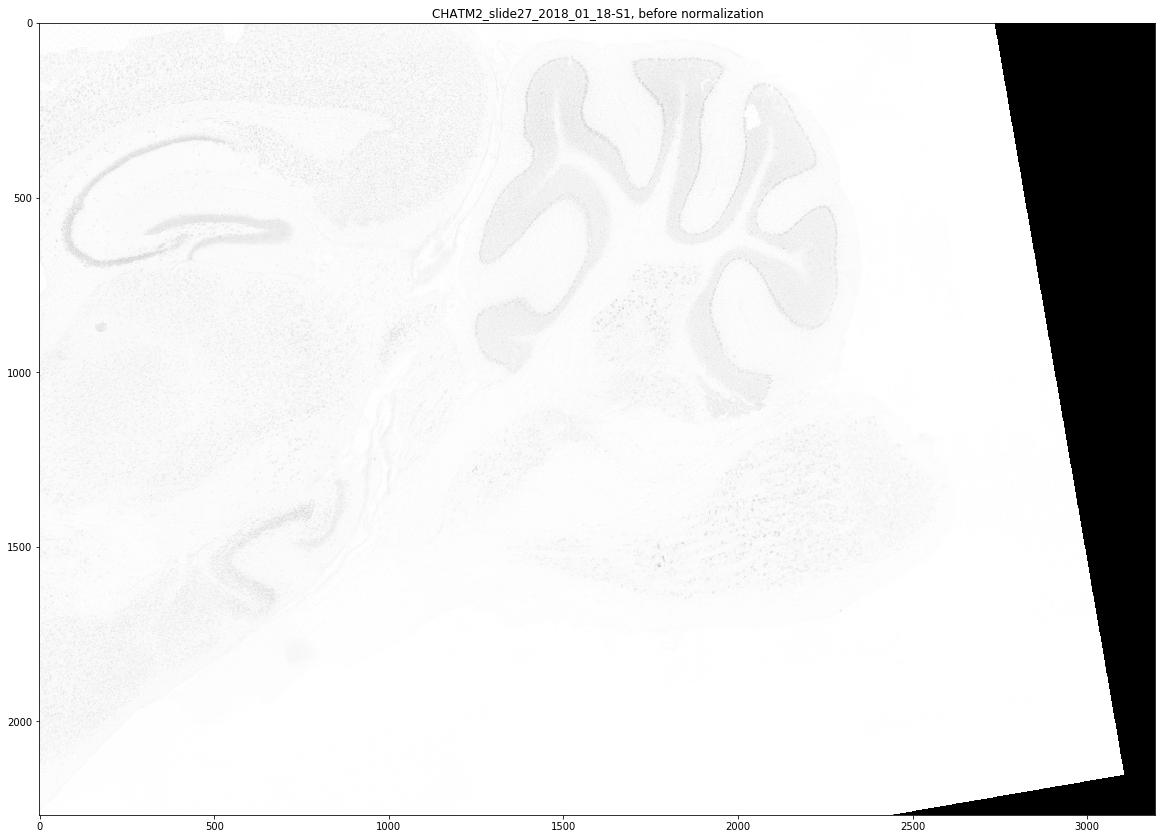

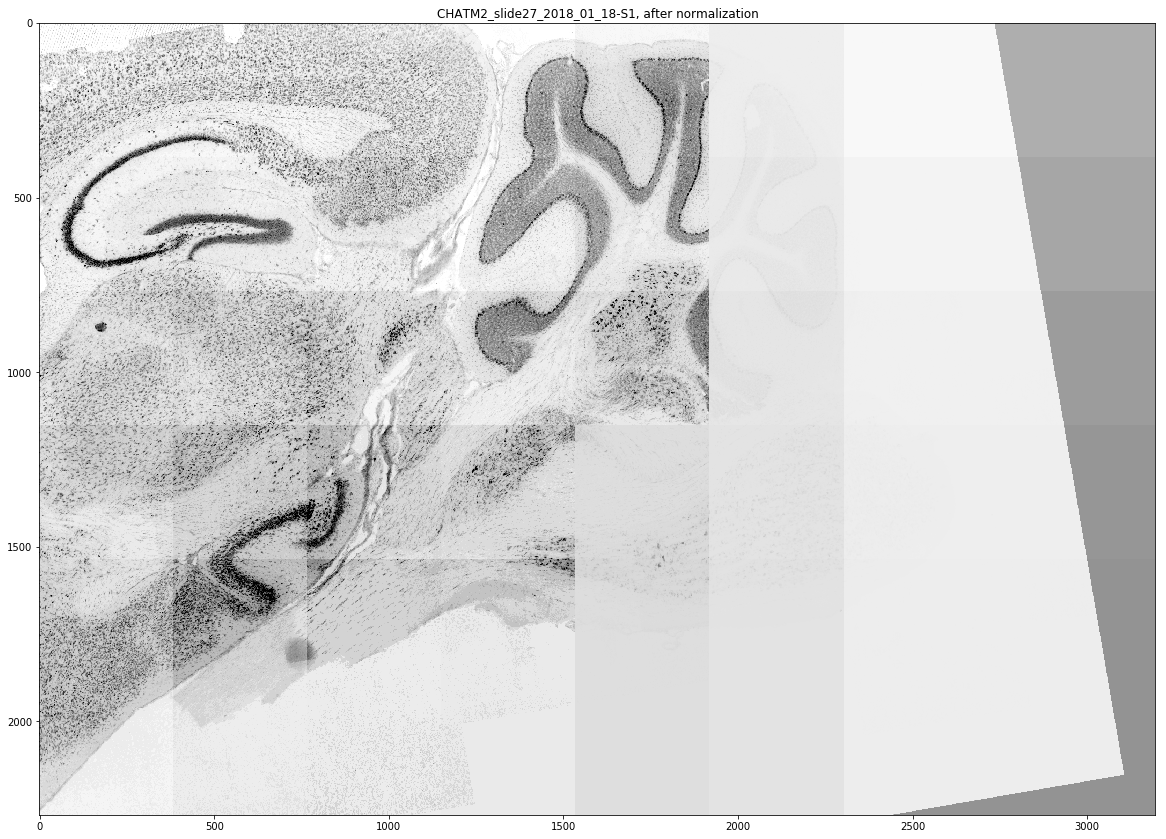

In [16]:
for stack, fn, version in image_identifiers:
    
    NorF = DataManager.get_brightfield_or_fluorescence(stack=stack, fn=fn)
    
    img = DataManager.load_image_v2(stack=stack, prep_id=2, fn=fn, version=version)
    img = img[::8, ::8]
    
    window_size_px = int(window_size_um / planar_resolution[stack]) / 8
    window_spacing_px = int(window_spacing_um / planar_resolution[stack]) / 8
    
    img_after_normalization = normalize_image(img, window_size=window_size_px, window_spacing=window_spacing_px)
    
    if NorF == 'N':
        vmin = -6
        vmax = 1
        img_before_normalization = rescale_intensity_v2(img, img.min(), img.max())
    else:
        vmin = 6 
        vmax = -1
        img_before_normalization = rescale_intensity_v2(img, img.max(), img.min())
    
    img_before_normalization_ubyte = rescale_intensity_v2(img_before_normalization, 0, 255)
    img_after_normalization_ubyte = rescale_intensity_v2(img_after_normalization, vmin, vmax)
    
    plt.figure(figsize=(20,20));
    plt.imshow(img_before_normalization_ubyte, cmap=plt.cm.gray, vmin=0, vmax=255);
    plt.title('%s, before normalization' % fn);
    plt.show();
    
    plt.figure(figsize=(20,20));
    plt.imshow(img_after_normalization_ubyte, cmap=plt.cm.gray, vmin=0, vmax=255);
    plt.title('%s, after normalization' % fn);
    plt.show();

In [9]:
def normalize_image(img, window_size=3000, window_spacing=1000):
    
    img_calib = np.zeros(img.shape, np.float)

    for cx in range(window_size/2, img.shape[1], window_spacing):
        for cy in range(window_size/2, img.shape[0], window_spacing):
    #         mu, std = mean_std_sample_locations[(cx, cy)]
            mu = img[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1].mean()
            std = img[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1].std()
            print cx, cy, mu, std
            
            if std > 0:            
#                 img_calib[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] = \
#                 .5 * img_calib[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] + \
#                 .5 * (img[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] - mu) / std
    
                img_calib[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] = \
                (img[cy-window_size/2:cy+window_size/2+1, cx-window_size/2:cx+window_size/2+1] - mu) / std
    return img_calib

CHATM2_slide27_2018_01_18-S2


Not using image_cache.


/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_Ntb/CHATM2_slide27_2018_01_18-S2_prep2_lossless_Ntb.tif
4615 4615 1679.0986233866163 1149.372224386217
4615 7691 1494.0839619144213 1076.473062653712
4615 10767 1285.2053898775305 969.3498752226363
4615 13843 845.7228057447211 953.8437728700588
4615 16919 626.7650819231802 911.6094058742158
7691 4615 1664.0222317420796 1177.785308953717
7691 7691 1459.9443828153385 1076.1656215998198
7691 10767 1118.9410704166548 1019.2114668926214
7691 13843 632.671190332923 876.0371247304917
7691 16919 321.7251616055489 674.337461320051
10767 4615 1684.893321138246 1288.1497643756686
10767 7691 1389.57557113775 1078.8114882662965
10767 10767 946.2828831592069 946.784167848391
10767 13843 472.0771136901479 679.0310012042191
10767 16919 183.49707907987232 412.463115974714
13843 4615 1684.513927350603 1418.274770035161
13843 7691 1566.2840080913625 1225.7967011003657
13843 10767 1070.4928359494222 1065.8250070833963
13843 138

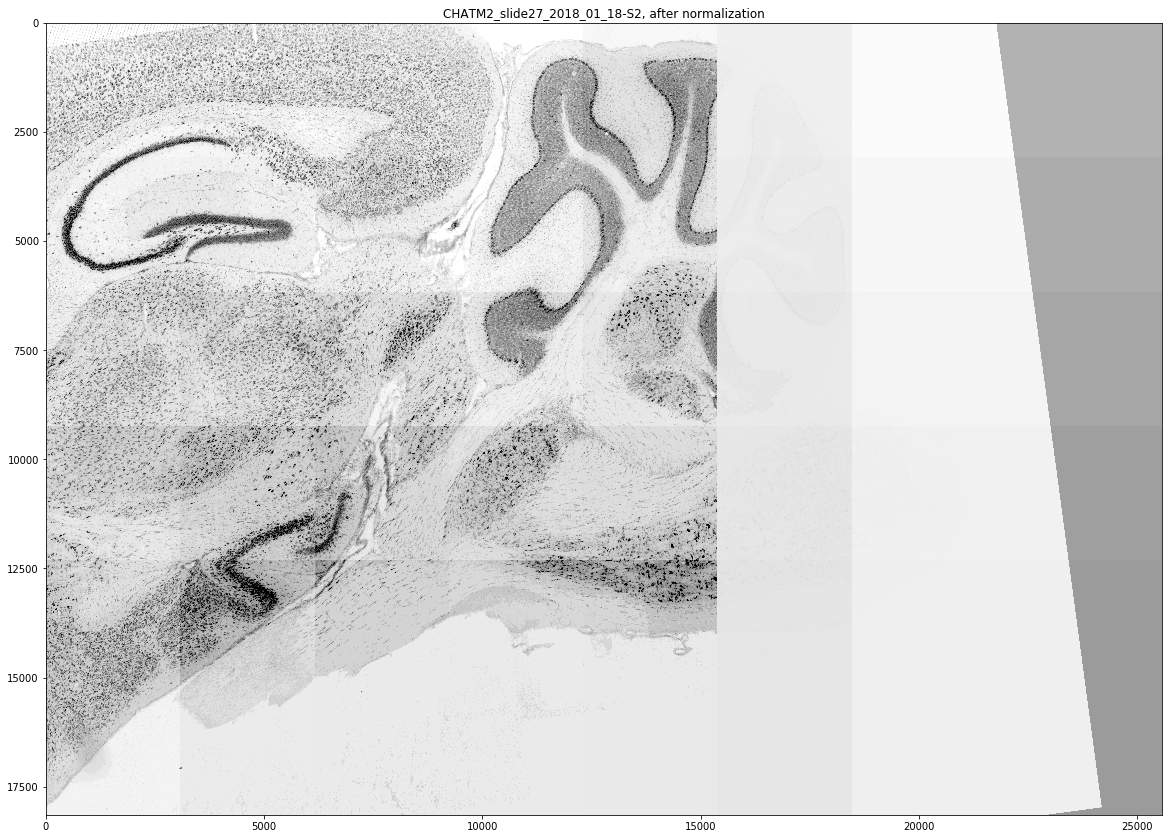

In [17]:
stack = 'CHATM2'

# for fn in metadata_cache['valid_filenames'][stack]:
for fn in ['CHATM2_slide27_2018_01_18-S2']:

    print fn
    
    img = DataManager.load_image_v2(stack=stack, prep_id=2, version='Ntb', fn=fn)
    
    window_size_px = int(window_size_um / planar_resolution[stack])
    window_spacing_px = int(window_spacing_um / planar_resolution[stack])
    
    img_after_normalization = normalize_image(img, window_size=window_size_px, window_spacing=window_spacing_px)
    
    vmin = 6 
    vmax = -1
    img_after_normalization_ubyte = rescale_intensity_v2(img_after_normalization, vmin, vmax)
    
    plt.figure(figsize=(20,20));
    plt.imshow(img_after_normalization_ubyte, cmap=plt.cm.gray, vmin=0, vmax=255);
    plt.title('%s, after normalization' % fn);
    plt.show();
    
#     fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=2, version='NtbWinNormalized', fn=fn)
#     create_parent_dir_if_not_exists(fp)
#     imsave(fp, img_after_normalization_ubyte)